In [1]:
import boto3
import botocore
import functools
from IPython.core.display import display, HTML
from iterdub import iterdub as ib
from iterpop import iterpop as ip
import itertools as it
import json
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from pandas.util import hash_pandas_object
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
from dishpylib.pyanalysis import calc_loglikelihoods_by_num_sets
from dishpylib.pyanalysis import count_hands_with_k_or_more_sets
from dishpylib.pyanalysis import count_hands_without_k_or_more_sets
from dishpylib.pyanalysis import estimate_interpolation_complexity
from dishpylib.pyanalysis import calc_loglikelihoods_over_set_sizes
from dishpylib.pyhelpers import get_control_t_distns
from dishpylib.pyhelpers import get_env_context
from dishpylib.pyhelpers import get_git_revision_hash
from dishpylib.pyhelpers import make_timestamp
from dishpylib.pyhelpers import NumpyEncoder
from dishpylib.pyhelpers import preprocess_competition_fitnesses
from dishpylib.pyhelpers import print_runtime


In [3]:
print_runtime()


context: ci
hostname: runnervm6whdl
interpreter: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]
notebook name: 2025-09-05-interpolation_complexity
notebook path: /home/runner/work/oee4/oee4/binder/2025-09-05-interpolation_complexity.ipynb
revision: bdac574
timestamp: 2025-09-08T20:12:23Z00:00

IPython==7.16.1
packaging==25.0


<ipython-input-3-4d790cf6450f>:1: DeprecatedWarning: print_runtime is deprecated. use nbmetalog package instead
  print_runtime()


In [4]:
teeplot_subdir = "2025-09-05-interpolation_complexity"


# get data


In [5]:
s3_handle = boto3.resource(
    's3',
    region_name="us-east-2",
    config=botocore.config.Config(
        signature_version=botocore.UNSIGNED,
    ),
)
bucket_handle = s3_handle.Bucket('prq49')

dfs = []
for stint in range(0, 101, 20):
    series_profiles, = bucket_handle.objects.filter(
        Prefix=f'endeavor=16/noncritical-phenotypeneutral-nopinterpolation-competitions/stage=6+what=collated/stint={stint}',
    )
    control_fits_df = get_control_t_distns('prq49', 16, stint)
    df = pd.read_csv(
        f's3://prq49/{series_profiles.key}',
        compression='xz',
    )
    df["Stint"] = stint
    dfdigest = '{:x}'.format( hash_pandas_object( df ).sum() )
    print(dfdigest)
    df = preprocess_competition_fitnesses(df, control_fits_df)
    dfs.append(df)


-50d269aea080f957
-74a9b13c2118fcba
ae46c308efd7bac
-4151220fa0cec517
-69964e21a4e4cfdb
5ea093cad6eb77b5


In [6]:
df = pd.concat(dfs, ignore_index=True)


# summarize data and model fitting


In [7]:
def log_lineplot(*args, **kwargs):
    sns.lineplot(*args, **kwargs)
    plt.yscale('log')
    plt.autoscale()

def lineplot_scatterplot(*args, **kwargs):
    sns.lineplot(
        *args,
        **{k : v for k, v in kwargs.items() if k != 'hue'},
        color='gray',
        zorder=1,
    )
    data = kwargs.pop("data")
    sns.scatterplot(
        *args,
        data=data[
            data[kwargs["hue"]] == "Significantly Deleterious"
        ],
        **kwargs,
        palette={
            'Significantly Advantageous' : sns.color_palette()[2],
            'Neutral' : sns.color_palette()[0],
            'Significantly Deleterious' : sns.color_palette()[1],
        },
        zorder=2,
        alpha=0.7,
    )
    sns.scatterplot(
        *args,
        data=data[
            data[kwargs["hue"]] != "Significantly Deleterious"
        ],
        **kwargs,
        palette={
            'Significantly Advantageous' : sns.color_palette()[2],
            'Neutral' : sns.color_palette()[0],
            'Significantly Deleterious' : sns.color_palette()[1],
        },
        zorder=2,
        alpha=0.7,
    )
    print(
       data["Relative Fitness"].value_counts().to_dict()
    )

    plt.legend(
        handles=[
            matplotlib.patches.Patch(
                color=sns.color_palette()[2],
                label='Significantly Advantageous',
            ),
            matplotlib.patches.Patch(
                color=sns.color_palette()[0],
                label='Neutral',
            ),
            matplotlib.patches.Patch(
                color=sns.color_palette()[1],
                label='Significantly Deleterious',
            ),
        ],
    )
    plt.gca().figure.set_size_inches(3.5, 2.5)
    sns.move_legend(
        plt.gca(), "lower center",
        bbox_to_anchor=(.6, 1), ncol=1, title=None, frameon=False,
    )
    annotation = str(
        data["Relative Fitness"].value_counts().to_dict()
    ).replace(",", "\n")
    plt.gca().annotate(
        annotation,
        xy=(1.1, 0.5), xycoords="axes fraction",
        ha="center", va="center", fontsize=8,
        rotation=90
    )


{'Significantly Deleterious': 716, 'Neutral': 362, 'Significantly Advantageous': 186}
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=relative-fitness+stint=0+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=relative-fitness+stint=0+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


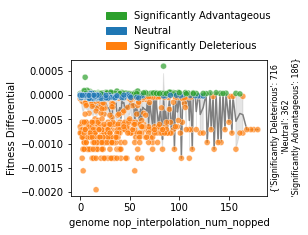

teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=0+viz=regplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=0+viz=regplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


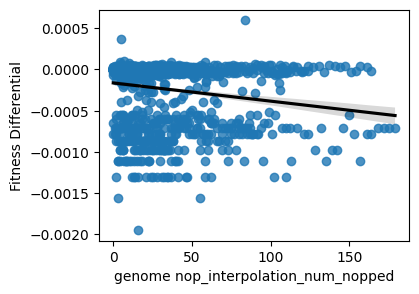

teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=0+viz=regplot+x=genome-nop-interpolation-num-nopped+y=is-deleterious+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=0+viz=regplot+x=genome-nop-interpolation-num-nopped+y=is-deleterious+ext=.png


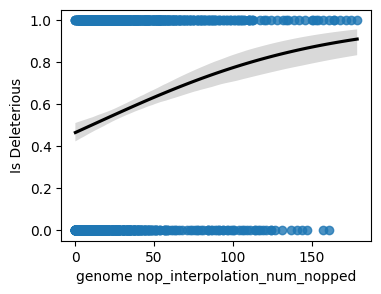

161.0


teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=set-size+stint=0+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=set-size+stint=0+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


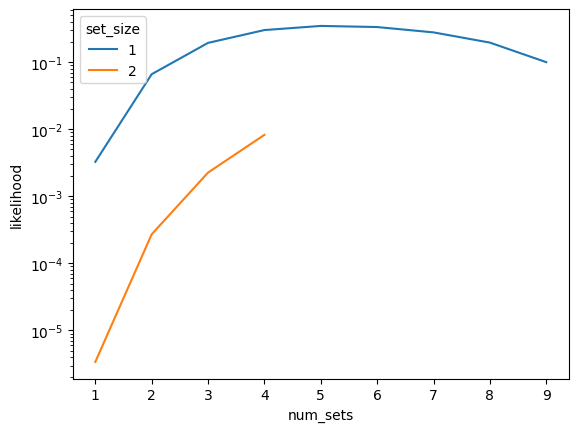

{'Significantly Deleterious': 1385, 'Neutral': 290, 'Significantly Advantageous': 113}
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=relative-fitness+stint=20+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=relative-fitness+stint=20+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


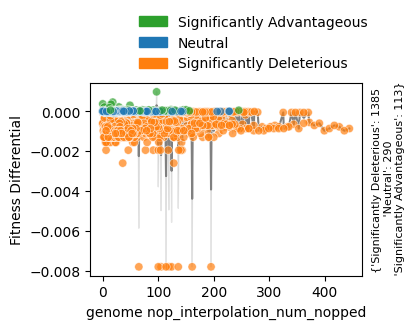

teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=20+viz=regplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=20+viz=regplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


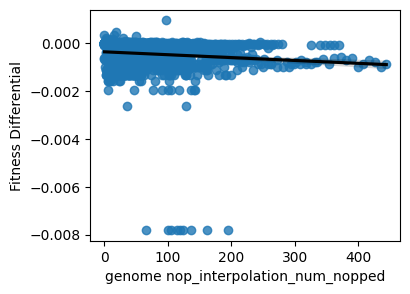

teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=20+viz=regplot+x=genome-nop-interpolation-num-nopped+y=is-deleterious+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=20+viz=regplot+x=genome-nop-interpolation-num-nopped+y=is-deleterious+ext=.png


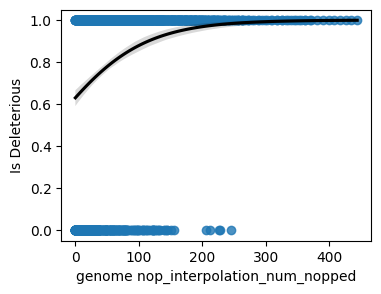

245.0


teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=set-size+stint=20+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=set-size+stint=20+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


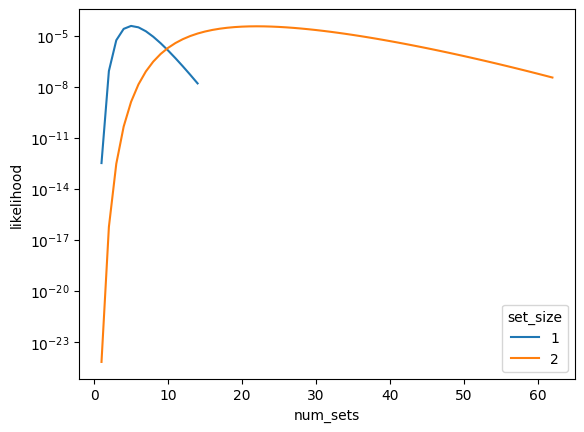

{'Significantly Deleterious': 1450, 'Neutral': 317, 'Significantly Advantageous': 120}
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=relative-fitness+stint=40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=relative-fitness+stint=40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


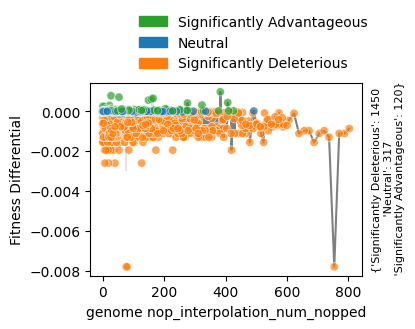

teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=40+viz=regplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=40+viz=regplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


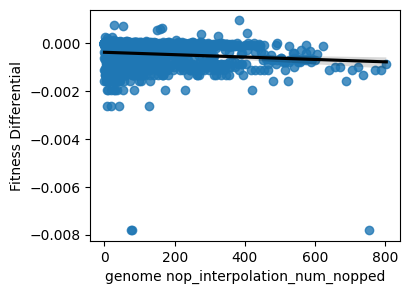

teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=40+viz=regplot+x=genome-nop-interpolation-num-nopped+y=is-deleterious+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=40+viz=regplot+x=genome-nop-interpolation-num-nopped+y=is-deleterious+ext=.png


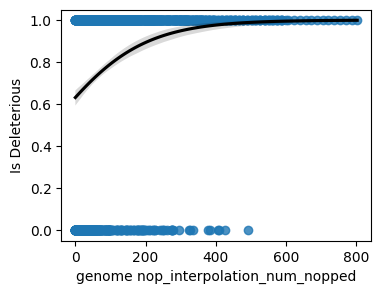

492.0


teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=set-size+stint=40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=set-size+stint=40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


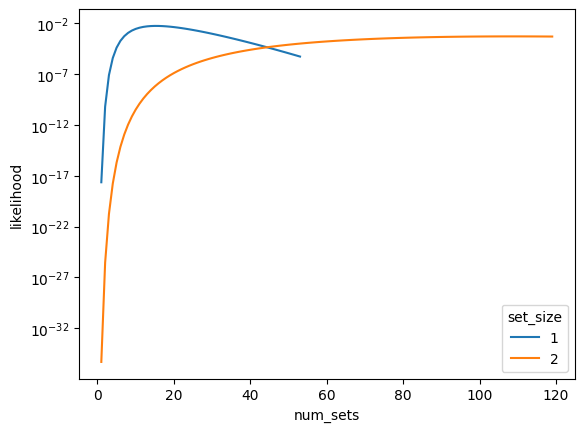

{'Significantly Deleterious': 1551, 'Neutral': 277, 'Significantly Advantageous': 74}
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=relative-fitness+stint=60+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=relative-fitness+stint=60+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


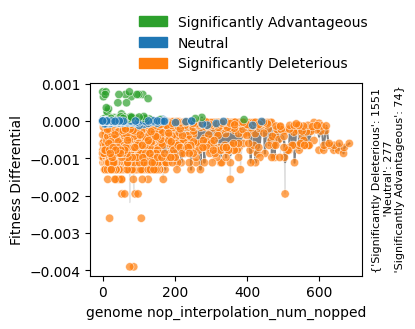

teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=60+viz=regplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=60+viz=regplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


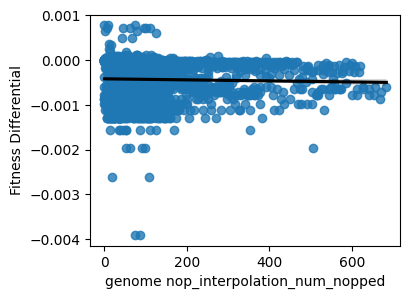

teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=60+viz=regplot+x=genome-nop-interpolation-num-nopped+y=is-deleterious+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=60+viz=regplot+x=genome-nop-interpolation-num-nopped+y=is-deleterious+ext=.png


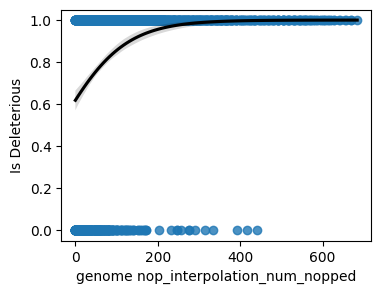

441.0


teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=set-size+stint=60+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=set-size+stint=60+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


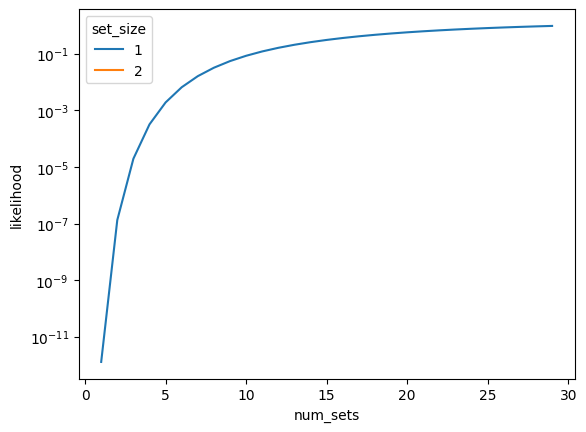

{'Significantly Deleterious': 1584, 'Neutral': 298, 'Significantly Advantageous': 82}
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=relative-fitness+stint=80+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=relative-fitness+stint=80+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


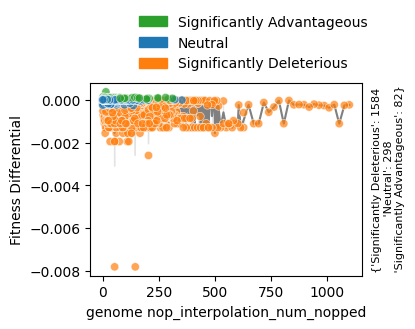

teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=80+viz=regplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=80+viz=regplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


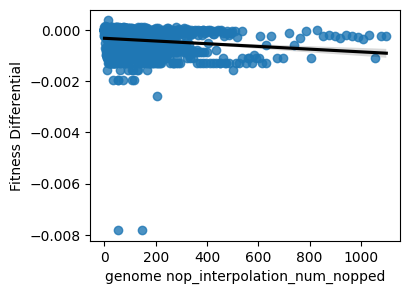

teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=80+viz=regplot+x=genome-nop-interpolation-num-nopped+y=is-deleterious+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=80+viz=regplot+x=genome-nop-interpolation-num-nopped+y=is-deleterious+ext=.png


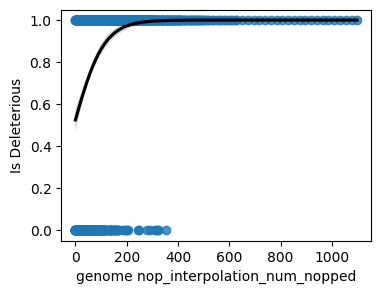

353.0


teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=set-size+stint=80+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=set-size+stint=80+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


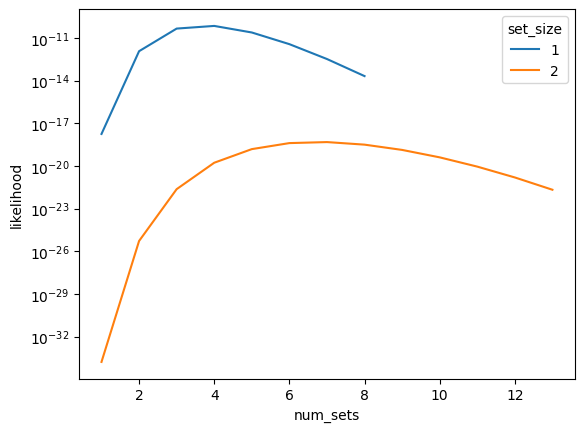

{'Significantly Deleterious': 1698, 'Neutral': 204, 'Significantly Advantageous': 33}
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=relative-fitness+stint=100+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=relative-fitness+stint=100+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


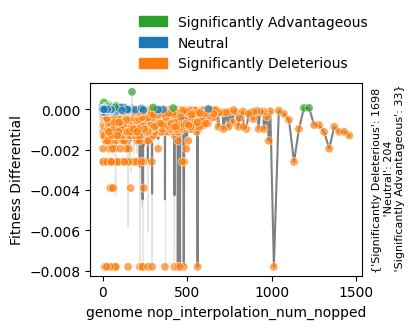

teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=100+viz=regplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=100+viz=regplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


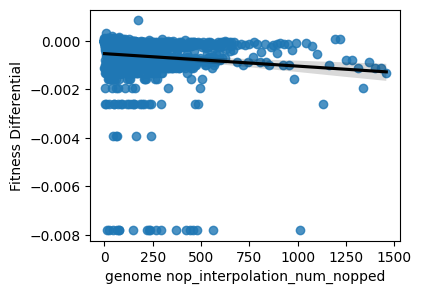

teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=100+viz=regplot+x=genome-nop-interpolation-num-nopped+y=is-deleterious+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+stint=100+viz=regplot+x=genome-nop-interpolation-num-nopped+y=is-deleterious+ext=.png


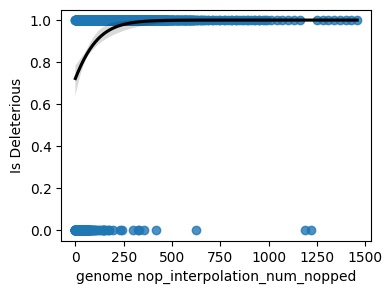

1220.0


teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=set-size+stint=100+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+hue=set-size+stint=100+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


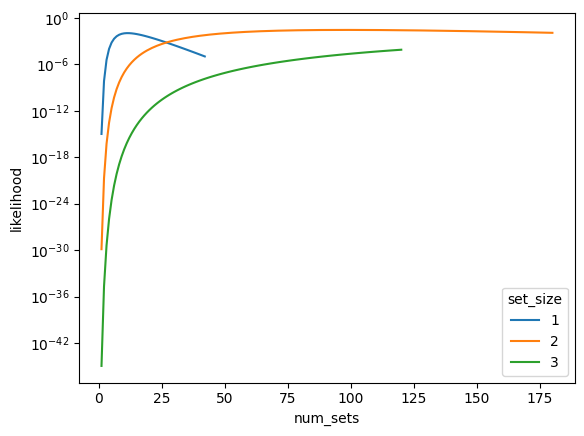

In [8]:
# display(HTML("<style>div.output_scroll { height: 1000em; }</style>"))

for stint in df['Stint'].unique():

    dfx = df[df['Stint'] == stint].copy()
    dfx["Is Deleterious"] = (dfx["Relative Fitness"] == "Significantly Deleterious").astype(float)

    display(HTML(f'<h1>stint {stint}</h1>'))


    display(HTML('<h2>interpolation competition</h2>'))
    tp.tee(
        lineplot_scatterplot,
        x='genome nop_interpolation_num_nopped',
        y='Fitness Differential',
        hue='Relative Fitness',
        data=dfx.dropna(subset=['genome nop_interpolation_num_nopped']),
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs={
            'stint' : str(stint),
            'bucket' : ib.dub( dfx['Treatment bucket'] ),
            'endeavor' : ib.dub( dfx['Competition Endeavor'] ),
        },
    )
    plt.show()

    with tp.teed(
        sns.regplot,
        data=dfx.dropna(subset=['genome nop_interpolation_num_nopped']),
        x='genome nop_interpolation_num_nopped',
        y='Fitness Differential',
        line_kws={"color": "black"},
        teeplot_outattrs={
            'stint': str(stint),
            'bucket': ib.dub(dfx['Treatment bucket']),
            'endeavor': ib.dub(dfx['Competition Endeavor']),
        },
        teeplot_subdir=teeplot_subdir,
    ):
        plt.gca().figure.set_size_inches(4, 3)

    plt.show()

    with tp.teed(
        sns.regplot,
        data=dfx.dropna(subset=['genome nop_interpolation_num_nopped']),
        x='genome nop_interpolation_num_nopped',
        y='Is Deleterious',
        logistic=True,
        line_kws={"color": "black"},
        teeplot_outattrs={
            'stint': str(stint),
            'bucket': ib.dub(dfx['Treatment bucket']),
            'endeavor': ib.dub(dfx['Competition Endeavor']),
        },
        teeplot_subdir=teeplot_subdir,
    ):
        plt.gca().figure.set_size_inches(4, 3)

    plt.show()

    display(HTML('<h2>model fit results</h2>'))
    dfxp = dfx.dropna(subset=['genome nop_interpolation_num_nopped', 'Is Deleterious'])


    # print genome size and max non-deleterious genome nop
    print(
        dfxp.loc[
            ~dfxp['Is Deleterious'].astype(bool),
            'genome nop_interpolation_num_nopped',
        ].max()
    )

    display(HTML('<h2>num_sets fitting</h2>'))
    def tee(plotter):
        tp.tee(
            plotter,
            x='num_sets',
            y='likelihood',
            hue='set_size',
            data=calc_loglikelihoods_over_set_sizes(
                series=16005,
                interpolation_competitions_df=dfx,
            ).astype({
                # so seaborn will color as categorical, not quantitative
                'set_size': 'str',
            }),
            teeplot_subdir=teeplot_subdir,
            teeplot_outattrs={
                'stint': str(stint),
                'bucket': ib.dub(dfx['Treatment bucket']),
                'endeavor': ib.dub(dfx['Competition Endeavor']),
            },
        )

    try:
        tee(log_lineplot)
    except ValueError:
        plt.clf()
        tee(sns.lineplot)
    plt.show()

    display(HTML('<h2>model fit results</h2>'))
    # print(json.dumps(
    #     estimate_interpolation_complexity(
    #         series=16005,
    #         interpolation_competitions_df=dfx,
    #     ),
    #     sort_keys=True,
    #     indent=4,
    #     cls=NumpyEncoder,
    # ))


161.0 179.0
[175.0, 179.0, 164.0, 172.0, 168.0, 164.0]


245.0 444.0
[252.0, 258.0, 263.0, 247.0, 249.0, 332.0, 287.0, 370.0, 257.0, 272.0, 355.0, 264.0, 362.0, 294.0, 310.0, 340.0, 302.0, 325.0, 347.0, 317.0, 279.0, 262.0, 251.0, 267.0, 256.0, 273.0, 272.0, 426.0, 344.0, 444.0, 335.0, 308.0, 399.0, 263.0, 317.0, 372.0, 408.0, 353.0, 362.0, 417.0, 290.0, 254.0, 299.0, 381.0, 390.0, 281.0, 326.0, 435.0]


492.0 803.0
[606.0, 541.0, 672.0, 688.0, 524.0, 508.0, 656.0, 754.0, 639.0, 623.0, 705.0, 721.0, 787.0, 803.0, 737.0, 557.0, 770.0, 574.0, 590.0, 551.0, 587.0, 575.0, 515.0, 539.0, 503.0, 527.0, 563.0, 576.0, 502.0, 527.0, 551.0, 539.0, 514.0, 588.0, 563.0, 600.0, 537.0, 585.0, 525.0, 549.0, 501.0, 513.0, 561.0, 573.0]


441.0 684.0
[580.0, 504.0, 618.0, 454.0, 492.0, 542.0, 517.0, 555.0, 467.0, 530.0, 479.0, 605.0, 568.0, 593.0, 641.0, 504.0, 477.0, 586.0, 491.0, 518.0, 600.0, 573.0, 559.0, 450.0, 627.0, 654.0, 464.0, 668.0, 545.0, 532.0, 613.0, 459.0, 471.0, 542.0, 506.0, 530.0, 577.0, 447.0, 483.0, 565.0, 553.0, 518.0, 495.0, 642.0, 489.0, 475.0, 586.0, 670.0, 614.0, 572.0, 600.0, 447.0, 684.0, 530.0, 544.0, 628.0, 461.0, 656.0, 516.0, 503.0, 558.0, 569.0, 468.0, 582.0, 519.0, 557.0, 531.0, 456.0, 481.0, 544.0, 493.0, 506.0, 607.0, 595.0, 620.0, 443.0, 526.0, 457.0, 469.0, 480.0, 491.0, 514.0, 446.0, 537.0, 549.0, 503.0, 560.0]


353.0 1099.0
[444.0, 373.0, 484.0, 464.0, 363.0, 393.0, 454.0, 383.0, 423.0, 434.0, 494.0, 403.0, 413.0, 474.0, 377.0, 411.0, 386.0, 403.0, 369.0, 394.0, 361.0, 359.0, 384.0, 474.0, 628.0, 500.0, 551.0, 615.0, 590.0, 397.0, 525.0, 461.0, 577.0, 513.0, 538.0, 487.0, 410.0, 602.0, 423.0, 449.0, 372.0, 436.0, 564.0, 987.0, 538.0, 381.0, 426.0, 650.0, 606.0, 628.0, 1009.0, 830.0, 1032.0, 964.0, 359.0, 673.0, 807.0, 583.0, 1054.0, 1099.0, 493.0, 852.0, 897.0, 785.0, 449.0, 516.0, 763.0, 740.0, 404.0, 942.0, 1077.0, 875.0, 561.0, 471.0, 718.0, 920.0, 695.0, 435.0, 446.0, 456.0, 477.0, 384.0, 363.0, 394.0, 508.0, 425.0, 373.0, 404.0, 498.0, 487.0, 415.0, 467.0, 381.0, 356.0, 373.0, 398.0, 365.0, 389.0, 406.0]


1220.0 1458.0
[1458.0, 1369.0, 1279.0, 1398.0, 1309.0, 1428.0, 1339.0, 1250.0]


teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+viz=plot-logistic-fit+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+viz=plot-logistic-fit+ext=.png


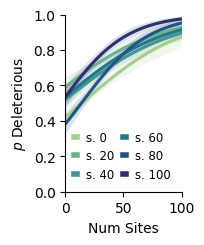

In [9]:
# display(HTML("<style>div.output_scroll { height: 1000em; }</style>"))
def plot_logistic_fit():
    xlim = None
    cmap = sns.color_palette("crest", as_cmap=True)
    hues = [
        cmap(i) for i in np.linspace(0, 1, len(df['Stint'].unique()))
    ]
    for stint, hue in zip(df['Stint'].unique(), hues):

        dfx = df[df['Stint'] == stint].copy()
        dfx["Is Deleterious"] = (dfx["Relative Fitness"] == "Significantly Deleterious").astype(float)

        max_neutral = dfx.loc[
            ~dfx['Is Deleterious'].astype(bool),
            'genome nop_interpolation_num_nopped',
        ].max()
        print(max_neutral, dfx['genome nop_interpolation_num_nopped'].max())
        print(
            dfx.loc[
                dfx["genome nop_interpolation_num_nopped"] > max_neutral,
                "genome nop_interpolation_num_nopped",
            ].tolist()
        )


        display(HTML(f'<h1>stint {stint}</h1>'))


        display(HTML('<h2>interpolation competition</h2>'))
        data = dfx.dropna(subset=['genome nop_interpolation_num_nopped'])
        data = data[data['genome nop_interpolation_num_nopped'] <= 100]
        ax = sns.regplot(
            data=data,
            x='genome nop_interpolation_num_nopped',
            y='Is Deleterious',
            logistic=True,
            scatter=False,
            color=hue,
        )
        if xlim is None:
            xlim = ax.get_xlim()

    ax.set_xlim(0, 100)
    ax.figure.set_size_inches(1.5, 2.3)
    ax.set_ylim(0, 1)
    ax.legend(
        handles=[
            plt.Line2D([0], [0], color=hue, lw=4)
            for hue in hues
        ],
        labels=[f"s. {stint}" for stint in df['Stint'].unique()],
        # bbox_to_anchor=(1.05, 1),
        loc='lower right',
        fontsize='small',
        ncol=2,
        handlelength=0.3,
        columnspacing=0.7,
        frameon=False,
    )
    ax.set_ylabel("$p$ Deleterious")
    ax.set_xlabel("Num Sites")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


tp.tee(
    plot_logistic_fit,
    teeplot_subdir=teeplot_subdir,
    teeplot_outattrs={
        'bucket' : ib.dub( df['Treatment bucket'] ),
        'endeavor' : ib.dub( df['Competition Endeavor'] ),
    },
)


In [10]:
from typing import Iterable
from math import prod
from scipy.stats import hypergeom

def min_skeleton_size(
    genome_size: int,
    knockout_sizes: Iterable[int],
    confidence: float = 0.95,
) -> int:
    """
    Return the minimum skeleton_size s such that
        Π_i (1 - P_i_success(s)) >= 1 - confidence,
    where P_i_success(s) is the probability that knockout i (size k_i) samples
    ALL of the s skeleton sites from a genome of size n.

    Success probability for one knockout of size k:
        P_success = hypergeom.pmf(s; M=n, n=s, N=k)
                   = C(n - s, k - s) / C(n, k) if k >= s else 0
    Failure probability = 1 - P_success.
    """
    n = int(genome_size)
    ks = [n - int(k) for k in knockout_sizes]

    if n < 0 or any(k < 0 or k > n for k in ks):
        raise ValueError("All knockout_sizes must be integers in [0, genome_size].")
    if not (0.0 < confidence < 1.0):
        raise ValueError("confidence must be in (0, 1).")

    alpha = 1.0 - confidence

    # If any knockout sampled the entire genome, success would be certain for any s <= n.
    # Observing all failures would then have probability 0 under this model.
    if any(k == n for k in ks) and n > 0:
        raise ValueError(
            "At least one knockout_size equals genome_size; observing all failures "
            "has probability 0 for any skeleton size."
        )

    def all_fail_prob(s: int) -> float:
        """Plain-space product Π_i (1 - hypergeom.pmf(s; M=n, n=s, N=k_i))."""
        terms = []
        for k in ks:
            if k < s:
                # Can't include all s skeleton sites when drawing fewer than s sites -> success prob 0
                terms.append(1.0)
            else:
                p_success = hypergeom.pmf(s, M=n, n=s, N=k)
                terms.append(1.0 - float(p_success))
        return prod(terms) if terms else 1.0

    # Monotone in s: as s increases, success gets harder, so all-fail probability increases.
    lo, hi = 0, n

    # Early-out
    if all_fail_prob(0) >= alpha:
        return 0

    while lo < hi:
        mid = (lo + hi) // 2
        if all_fail_prob(mid) >= alpha:
            hi = mid
        else:
            lo = mid + 1
    return lo

# ---- Example ----
# n = 10_000
# ks = [300, 450, 200, 500]
# print(min_skeleton_size(n, ks, confidence=0.95))


In [11]:
# display(HTML("<style>div.output_scroll { height: 1000em; }</style>"))
xlim = None
cmap = sns.color_palette("crest", as_cmap=True)
hues = [
    cmap(i) for i in np.linspace(0, 1, len(df['Stint'].unique()))
]
stints = []
genome_sizes = []
skeleton_lbs = []
skeleton_ubs = []
for stint, hue in zip(df['Stint'].unique(), hues):
    stints.append(stint)
    dfx = df[df['Stint'] == stint].copy()
    dfx["Is Deleterious"] = (dfx["Relative Fitness"] == "Significantly Deleterious").astype(float)

    max_neutral = dfx.loc[
        ~dfx['Is Deleterious'].astype(bool),
        'genome nop_interpolation_num_nopped',
    ].max()
    genome_sizes.append(
        dfx['genome nop_interpolation_num_nopped'].max(),
    )
    skeleton_ubs.append(
        genome_sizes[-1] - max_neutral,
    )
    past_neutral = dfx.loc[
        dfx["genome nop_interpolation_num_nopped"] > max_neutral,
        "genome nop_interpolation_num_nopped",
    ].tolist()
    skeleton_lbs.append(
        min_skeleton_size(
            dfx['genome nop_interpolation_num_nopped'].max(),
            past_neutral,
            confidence=0.5
        ),
    )

print(stints)
print(genome_sizes)
print(skeleton_lbs)
print(skeleton_ubs)
res_df = pd.DataFrame({
    "Stint": stints,
    "Genome Size": genome_sizes,
    "Skeleton LB": skeleton_lbs,
    "Skeleton UB": skeleton_ubs
})
res_df


[0, 20, 40, 60, 80, 100]
[179.0, 444.0, 803.0, 684.0, 1099.0, 1458.0]
[1, 4, 4, 4, 10, 1]
[18.0, 199.0, 311.0, 243.0, 746.0, 238.0]


,Stint,Genome Size,Skeleton LB,Skeleton UB
0,0,179.0,1,18.0
1,20,444.0,4,199.0
2,40,803.0,4,311.0
3,60,684.0,4,243.0
4,80,1099.0,10,746.0
5,100,1458.0,1,238.0


teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+viz=plot-skeleton+ext=.pdf
teeplots/2025-09-05-interpolation_complexity/bucket=prq49+endeavor=16+viz=plot-skeleton+ext=.png


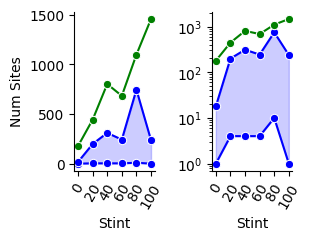

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_skeleton():
    fig, axes = plt.subplots(1, 2, figsize=(3.2, 2.5), sharex=True, sharey=False)

    # Common y-ticks
    yticks = [0, 20, 40, 60, 80, 100]

    # --- First plot: full height ---
    sns.lineplot(
        data=res_df,
        x="Stint",
        y="Skeleton LB",
        color="blue",
        marker="o",
        ax=axes[0]
    )
    sns.lineplot(
        data=res_df,
        x="Stint",
        y="Skeleton UB",
        color="blue",
        marker="o",
        ax=axes[0]
    )
    sns.lineplot(
        data=res_df,
        x="Stint",
        y="Genome Size",
        color="green",
        marker="o",
        ax=axes[0]
    )
    axes[0].fill_between(
        res_df["Stint"],
        res_df["Skeleton LB"],
        res_df["Skeleton UB"],
        color="blue",
        alpha=0.2
    )
    axes[0].set_xticks(yticks)
    axes[0].set_xticklabels(yticks, rotation=60)
    axes[0].set_ylabel("Num Sites")
    axes[0].spines["top"].set_visible(False)
    axes[0].spines["right"].set_visible(False)
    # --- Second plot: restricted y-range 0–20 ---
    sns.lineplot(
        data=res_df,
        x="Stint",
        y="Skeleton LB",
        color="blue",
        marker="o",
        ax=axes[1]
    )
    sns.lineplot(
        data=res_df,
        x="Stint",
        y="Skeleton UB",
        color="blue",
        marker="o",
        ax=axes[1]
    )
    sns.lineplot(
        data=res_df,
        x="Stint",
        y="Genome Size",
        color="green",
        marker="o",
        ax=axes[1]
    )
    axes[1].fill_between(
        res_df["Stint"],
        res_df["Skeleton LB"],
        res_df["Skeleton UB"],
        color="blue",
        alpha=0.2
    )
    axes[1].set_yscale("log")
    axes[1].set_xticks(yticks)
    axes[1].set_xticklabels(yticks, rotation=60)
    axes[1].set_ylabel("")
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
    plt.tight_layout()

tp.tee(
    plot_skeleton,
    teeplot_subdir=teeplot_subdir,
    teeplot_outattrs={
        'bucket' : ib.dub( df['Treatment bucket'] ),
        'endeavor' : ib.dub( df['Competition Endeavor'] ),
    },
)
